In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import inspect
import warnings
import cProfile

from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

import palettable
color_fancy = palettable.wesanderson.Mendl_4.mpl_colors
color_bins = palettable.cartocolors.qualitative.Bold_4_r.mpl_colors

### Learn how to use `astroplan` and `astropy` for observing planning

* [`astroplan` can be found here](https://astroplan.readthedocs.io/en/latest/)

In [3]:
from astroplan import download_IERS_A
download_IERS_A()

In [16]:
from astroplan import Observer
from astroplan import FixedTarget
from astroplan.plots import plot_airmass, dark_style_sheet

from pytz import timezone

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_moon

In [13]:
# Site
ctio_timezone = timezone('Etc/GMT-4')
ctio = Observer.at_site('CTIO', timezone=ctio_timezone)

# Target
g09 = FixedTarget(name='G09', coord=SkyCoord(135.0, 0.5, unit='deg', frame='icrs'))

# Planned observing time (UTC)
obs_time = Time('2021-04-01 00:00:00', scale='utc')
obs_day = obs_time + np.linspace(-12, 12, 100) * u.hour

In [15]:
ctio.altaz(obs_day, g09).secz

<Quantity [ -1.20424834,  -1.18370826,  -1.16848858,  -1.15826554,
            -1.15282727,  -1.1520629 ,  -1.15595692,  -1.1645885 ,
            -1.17813535,  -1.19688288,  -1.22123918,  -1.2517576 ,
            -1.28916922,  -1.33442897,  -1.38878127,  -1.45385428,
            -1.53179739,  -1.62548628,  -1.73883655,  -1.87729892,
            -2.04867087,  -2.26448763,  -2.54253987,  -2.91174742,
            -3.42243576,  -4.17058497,  -5.36470709,  -7.55900798,
           -12.87653042, -43.99627979,  30.9793775 ,  11.47541571,
             7.06022711,   5.11388694,   4.02176631,   3.32528065,
             2.8443538 ,   2.49387302,   2.22839479,   2.02145708,
             1.85661652,   1.72312708,   1.61367906,   1.52313687,
             1.44779649,   1.38492919,   1.3324909 ,   1.28893131,
             1.25306532,   1.22398475,   1.20099677,   1.18358061,
             1.17135723,   1.16406848,   1.16156349,   1.16379092,
             1.1707964 ,   1.18272483,   1.19982777,   1.22247

<Time object: scale='utc' format='jd' value=2459305.6994978697>

In [40]:
sunset = ctio.sun_set_time(ctio_time, which='nearest')

print(sunset.iso)

2021-03-31 22:36:40.821


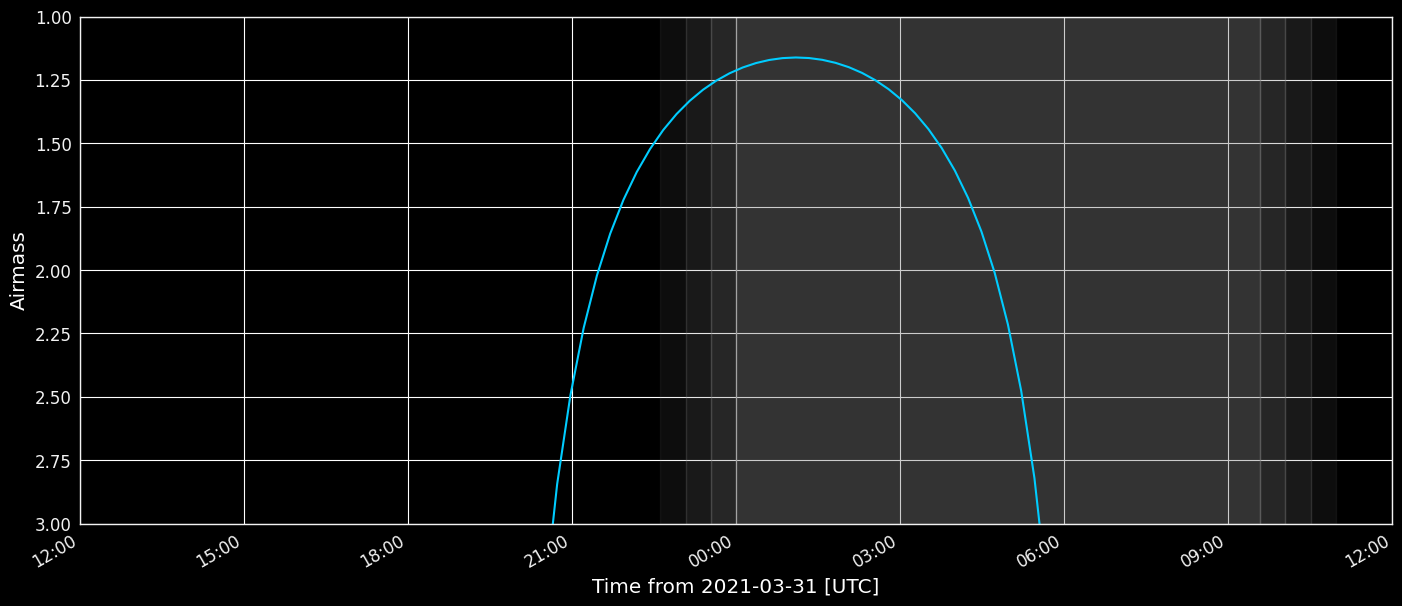

In [19]:
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(left=0.12, right=0.995, bottom=0.15, top=0.995, wspace=0.00, hspace=0.2)

ax = fig.add_subplot(111)

plot_airmass(g09, ctio, ctio_time, brightness_shading=True, style_sheet=dark_style_sheet) 